In [1]:
%matplotlib inline 
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
raw_img = skimage.io.imread('campus.tiff')

In [3]:
raw_img

array([[200, 306, 217, ..., 199, 177, 219],
       [379, 203, 347, ..., 185, 215, 190],
       [225, 388, 216, ..., 211, 177, 235],
       ...,
       [901, 584, 929, ..., 302, 412, 304],
       [520, 909, 494, ..., 396, 268, 408],
       [893, 578, 905, ..., 307, 390, 311]], dtype=uint16)

In [4]:
raw_img.shape

(4016, 6016)

In [5]:
print(f'size {raw_img.shape}, min value {raw_img.min()}, max value {raw_img.max()}, type {raw_img.dtype}') # 16 bit unsigned int

size (4016, 6016), min value 147, max value 4087, type uint16


In [6]:
dp_arr_img = skimage.img_as_float(raw_img) # double precision array convert 

In [65]:
def plot_fig(fig1, fig2, name='img_temp.png'):
    fig = plt.figure(figsize=(14, 8))
    fig.add_subplot(1, 2, 1)
    plt.imshow(fig1, cmap='gray')
    plt.axis('off')
    fig.add_subplot(1, 2, 2)
    plt.imshow(fig2, cmap='gray')
    plt.axis('off')
    plt.savefig(name)

    plt.show()

In [66]:
dp_arr_img

array([[0.0030518 , 0.00466926, 0.00331121, ..., 0.00303655, 0.00270085,
        0.00334173],
       [0.00578317, 0.00309758, 0.00529488, ..., 0.00282292, 0.00328069,
        0.00289921],
       [0.00343328, 0.0059205 , 0.00329595, ..., 0.00321965, 0.00270085,
        0.00358587],
       ...,
       [0.01374838, 0.00891127, 0.01417563, ..., 0.00460822, 0.00628672,
        0.00463874],
       [0.00793469, 0.01387045, 0.00753796, ..., 0.00604257, 0.00408942,
        0.00622568],
       [0.01362631, 0.00881971, 0.01380941, ..., 0.00468452, 0.00595102,
        0.00474556]])

In [67]:
print(f'size {dp_arr_img.shape}, min value {dp_arr_img.min()}, max value {dp_arr_img.max()}, type {dp_arr_img.dtype}')

size (4016, 6016), min value 0.002243076218814374, max value 0.062363622491798276, type float64


darkness 150, saturation 4095
we want 150 -> 0, 4095 -> 1.
Subtract 150 and divide by 4095-150. then clip. 

In [68]:
darkness = 150
saturation = 4095

In [69]:
def linearize_image(img, dark, sat):
    img_transform = (img - dark) / (sat - dark)
    img_final = np.clip(img_transform, 0, 1)
    return img_final

In [70]:
lin_img = linearize_image(raw_img, 150, 4095)

In [71]:
print(f'size {lin_img.shape}, min value {lin_img.min()}, max value {lin_img.max()}, type {lin_img.dtype}')

size (4016, 6016), min value 0.0, max value 1.0, type float64


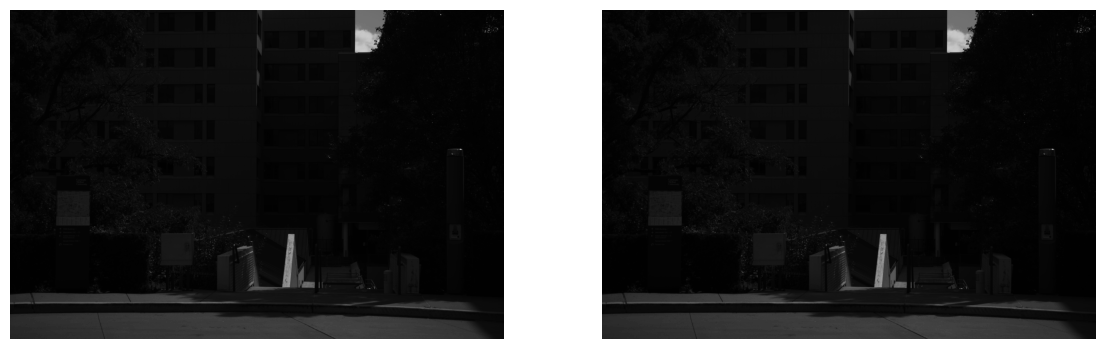

In [72]:
plot_fig(raw_img, lin_img, 'linearize.png')

In [73]:
# RGB, bayer 
grbg = np.array([[[0, 1], [0, 0]], [[1, 0], [0, 1]], [[0, 0], [1, 0]]])
rggb = np.array([[[1, 0], [0, 0]], [[0, 1], [1, 0]], [[0, 0], [0, 1]]])
bggr = np.array([[[0, 0], [0, 1]], [[0, 1], [1, 0]], [[1, 0], [0, 0]]])
gbrg = np.array([[[0, 0], [1, 0]], [[1, 0], [0, 1]], [[0, 1], [0, 0]]])

In [74]:
grbg.shape

(3, 2, 2)

In [75]:
def preprocess(array):
    temp = np.transpose(array, (1, 2, 0))
    return temp/temp.max()

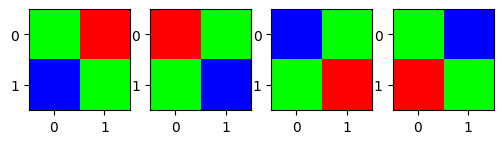

In [76]:
fig = plt.figure(figsize=(6, 3))
fig.add_subplot(1, 4, 1)
plt.imshow(preprocess(grbg), cmap='gray')
fig.add_subplot(1, 4, 2)
plt.imshow(preprocess(rggb), cmap='gray')
fig.add_subplot(1, 4, 3)
plt.imshow(preprocess(bggr), cmap='gray')
fig.add_subplot(1, 4, 4)
plt.imshow(preprocess(gbrg), cmap='gray')
plt.savefig('data/bayer_kernels.png')

In [77]:
patch = lin_img[0:2, 0:2]

In [78]:
patch.shape

(2, 2)

In [79]:
img1 = lin_img[0::2, 0::2]
img2 = lin_img[0::2, 1::2]
img3 = lin_img[1::2, 0::2]

im_rgb = np.dstack((img1, img2, img3)) # im1=R, im2=G, im3=B. What does RGB map to? that will tell Bayer's pattern

(2008, 3008, 3)

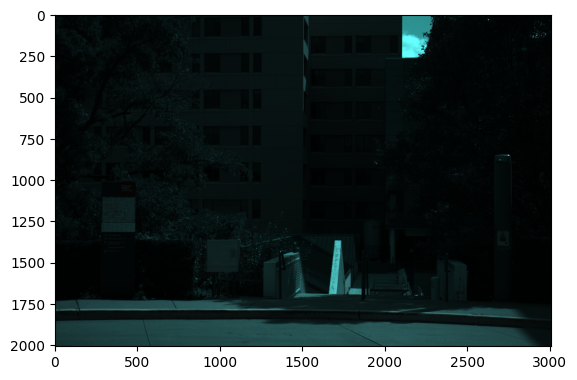

In [80]:
plt.imshow(im_rgb, cmap='gray')
im_rgb.shape

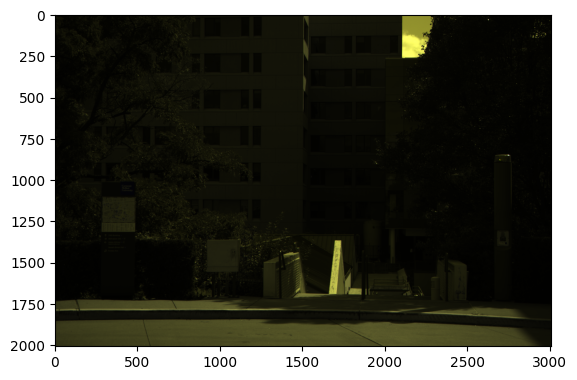

In [81]:
# Potential correct Bayer pattern is bggr 
img_bgr = np.dstack((img3, img2, img1))
plt.imshow(img_bgr, cmap='gray')

In [82]:
img_bgr.shape

(2008, 3008, 3)

In [83]:
topleft_patch = im_rgb[0:2, 0:2, :]
topleft_patch = np.transpose(topleft_patch, (2, 0, 1))
topleft_patch.shape

(3, 2, 2)

In [84]:
def bayer(patch, pattern):
    ans = patch * pattern
    print(ans)
    print(ans.sum())

In [85]:
bayer(topleft_patch, grbg)
bayer(topleft_patch, rggb)
bayer(topleft_patch, bggr) # should be this!
bayer(topleft_patch, gbrg)

[[[0.         0.01698352]
  [0.         0.        ]]

 [[0.03954373 0.        ]
  [0.         0.04790875]]

 [[0.         0.        ]
  [0.05931559 0.        ]]]
0.16375158428390368
[[[0.01267427 0.        ]
  [0.         0.        ]]

 [[0.         0.04258555]
  [0.06032953 0.        ]]

 [[0.         0.        ]
  [0.         0.04942966]]]
0.1650190114068441
[[[0.         0.        ]
  [0.         0.01673004]]

 [[0.         0.04258555]
  [0.06032953 0.        ]]

 [[0.05804816 0.        ]
  [0.         0.        ]]]
0.17769328263624842
[[[0.         0.        ]
  [0.01901141 0.        ]]

 [[0.03954373 0.        ]
  [0.         0.04790875]]

 [[0.         0.04993663]
  [0.         0.        ]]]
0.15640050697084917


In [86]:
def grey_world_balancing(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    ru, gu, bu = R.mean(), G.mean(), B.mean()
    print(ru, gu, bu)
    
    R = R * (gu / ru)
    G = G * 1
    B = B * (gu / bu)
    
    return np.dstack((R, G, B))

0.07227460491978899 0.07222206441103156 0.030807273301758312


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.05843464754419284 0.07222206441103164


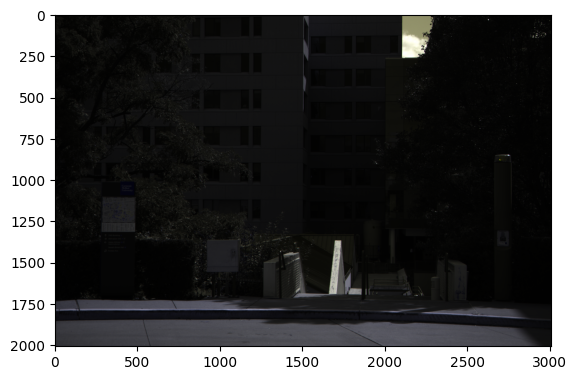

In [87]:
grey_balance = grey_world_balancing(img_bgr)
print(img_bgr.mean(), grey_balance.mean())
plt.imshow(grey_balance, cmap='gray')
# temp = (grey_balance - grey_balance.min()) / (grey_balance.max() - grey_balance.min())
plt.savefig('grey_balance.png')

In [88]:
def white_world_balancing(img):
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    ru, gu, bu = R.max(), G.max(), B.max()
    print(ru, gu, bu)
    
    R = R * (gu / ru)
    G = G * 1
    B = B * (gu / bu)
    
    return np.dstack((R, G, B))

0.0 1.0
0.9979721166032953 0.9979721166032953 1.0
0.0 0.9979721166032953


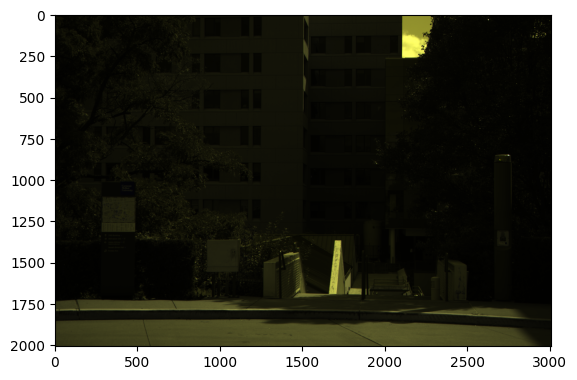

In [89]:
print(img_bgr.min(), img_bgr.max())
white_balance = white_world_balancing(img_bgr)
print(white_balance.min(), white_balance.max())
plt.imshow(white_balance, cmap='gray')
plt.savefig('whitew_balance.png')

In [90]:
def preset_white_balancing(img):
    '''
    multipliers 2.394531 1.000000 1.597656 1.000000
    '''
    R = img[:, :, 0]
    G = img[:, :, 1]
    B = img[:, :, 2]
    R = R * 2.394531
    B = B * 1.597656
    return np.dstack((R, G, B))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.0 2.3896751703422057


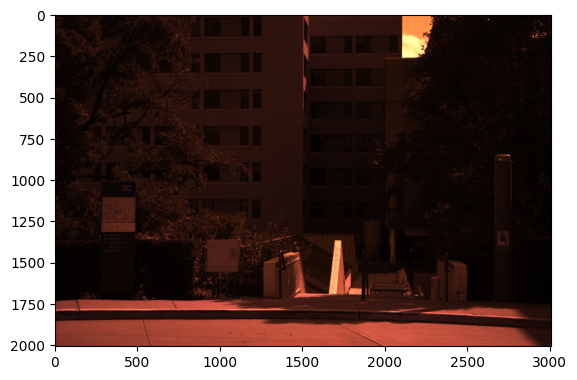

In [91]:
preset_balance = preset_white_balancing(img_bgr)
print(preset_balance.min(), preset_balance.max())
plt.imshow(preset_balance, cmap='gray')
plt.savefig('preset_balance.png')

In [92]:
img_bgr.shape

(2008, 3008, 3)

## Demosaic 

In [93]:
# img1 = lin_img[0::2, 0::2]
# img2 = lin_img[0::2, 1::2]
# img3 = lin_img[1::2, 0::2]
# img_bgr = np.dstack((img3, img2, img1))

In [48]:
import scipy.interpolate

H, W = lin_img.shape
print(H, W)

x_2 = np.arange(0, H, 2)
y_2 = np.arange(0, W, 2)

x_1 = np.arange(0, H, 2)
y_1 = np.arange(1, W, 2)

x_0 = np.arange(1, H, 2)
y_0 = np.arange(0, W, 2)

4016 6016


In [94]:
# img 1
f_2 = scipy.interpolate.interp2d(y_2, x_2, img_bgr[:, :, 2])
f_1 = scipy.interpolate.interp2d(y_1, x_1, img_bgr[:, :, 1])
f_0 = scipy.interpolate.interp2d(y_0, x_0, img_bgr[:, :, 0])

In [96]:
r = np.arange(0, H)
c = np.arange(0, W)

channel2 = f_2(c, r)
channel1 = f_1(c, r)
channel0 = f_0(c, r)

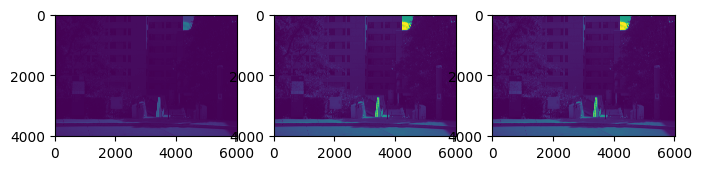

In [99]:
fig = plt.figure(figsize=(8, 6))
fig.add_subplot(1, 3, 1)
plt.imshow(channel2)
fig.add_subplot(1, 3, 2)
plt.imshow(channel1)
fig.add_subplot(1, 3, 3)
plt.imshow(channel0)
plt.show()
# plt.savefig('data/bayer_kernels.png')

In [55]:
print(img_bgr[:, :, 2].shape)
len(x_2), len(y_2)

(2008, 3008)


(2008, 3008)

In [ ]:
img_bgr[i, j, 2] # img1
img_bgr[i, j, 1] # img2
img_bgr[i, j, 0] # img3